# Yellow Taxi Demand Prediction in New York City

## Libraries

In [0]:
#!pip install graphviz
#!pip install cloudpickle
#!pip install dask
#!pip install folium
#!pip install gpxpy
#!apt-get install graphviz

In [0]:
# For dataframes
import dask.dataframe as dd
import pandas as pd

# Open Street Map
import folium

# UNIX time conversion
import datetime
import time

# Arithmetic operations on array
import numpy as np

# Plotting
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams

# For calculating distance between two points in miles
import gpxpy.geo

# For clustering
from sklearn.cluster import MiniBatchKMeans, KMeans

import math
import pickle
import os

# ML models
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Performance Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Data Information

Data Source - NYC Taxi and Limousine Commission (TLC) - https://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml


### Information on Taxies
#### Yellow Taxi: Yellow Medallion Taxicabs
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.
#### For Hire Vehicles (FHVs)
FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.
#### Green Taxi: Street Hail Livery (SHL)
The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides.

Credits: [Quora](https://www.quora.com/What-is-the-difference-between-Green-Cabs-and-Yellow-Cabs)

## Data Collection

Yellow Taxi trip data of 2016

In [0]:
import requests
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
  r = requests.get(url)
  f.write(r.content)

In [7]:
month = dd.read_csv('yellow_tripdata_2016-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


## Features in Dataset
**Source** - http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
<table border="1">
    <tr>
        <th>Field Name</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>VendorID</td>
        <td>
        A code indicating the TPEP provider that provided the record.
        <ol>
          <li>Creative Mobile Technologies</li>
          <li>VeriFone Inc.</li>
        </ol>
        </td>
    </tr>
    <tr>
        <td>tpep_pickup_datetime</td>
        <td>The date and time when the meter was engaged.</td>
    </tr>
    <tr>
        <td>tpep_dropoff_datetime</td>
        <td>The date and time when the meter was disengaged.</td>
    </tr>
    <tr>
        <td>Passenger_count</td>
        <td>The number of passengers in the vehicle. This is a driver-entered value.</td>
    </tr>
    <tr>
        <td>Trip_distance</td>
        <td>The elapsed trip distance in miles reported by the taximeter.</td>
    </tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
    <tr>
        <td>Store_and_fwd_flag</td>
        <td>
            This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br> 
            aka “store and forward,” because the vehicle did not have a connection to the server.<br>
            Y= store and forward trip<br>
            N= not a store and forward trip
        </td>
    </tr>
	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

## ML Problem Formulation
**Time Series Forcasting and Regression**
- To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.
- To solve the above I am using data collected in Jan - Mar 2016 to predict the pickups in Jan - Mar 2017.

### Performance Metrics
1. Mean Absolute Percentage Error.
2. Mean Squared Error.

## Data Cleaning

Data Preview

In [8]:
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


### 1. Pickup Latitude & Pickup Longitude

New York is bounded by the location cordinates ( lat, long ) - (40.5774, -74.15) & (40.9176, -73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.</br>
Source for bounding coordinates - https://www.flickr.com/places/info/2459115

In [11]:
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# Displaying few points outside New York City
sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

### 2. Dropoff Latitude & Dropoff Longitude

In [12]:
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

### 3. Trip Duration

According to NYC Taxi & Limousine Commision Regulations the maximum **allowed trip duration in a 24 hour interval is 12 hours.**

In [0]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
  
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame
  
frame_with_durations = return_with_trip_times(month)

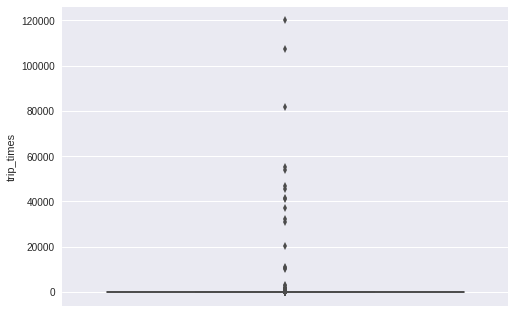

In [17]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [18]:
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -43.95
10 percentile value is 3.933333333333333
20 percentile value is 5.566666666666666
30 percentile value is 7.1
40 percentile value is 8.683333333333334
50 percentile value is 10.466666666666667
60 percentile value is 12.55
70 percentile value is 15.2
80 percentile value is 18.933333333333334
90 percentile value is 25.516666666666666
100 percentile value is  119912.7


In [19]:
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 25.516666666666666
91 percentile value is 26.55
92 percentile value is 27.733333333333334
93 percentile value is 29.116666666666667
94 percentile value is 30.733333333333334
95 percentile value is 32.7
96 percentile value is 35.233333333333334
97 percentile value is 38.666666666666664
98 percentile value is 43.916666666666664
99 percentile value is 53.9
100 percentile value is  119912.7


In [0]:
# removing outlier
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

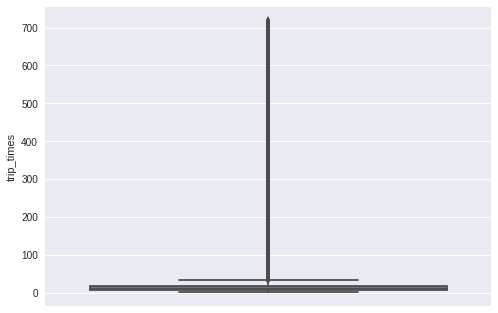

In [21]:
# plotting boxplot after removing data
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

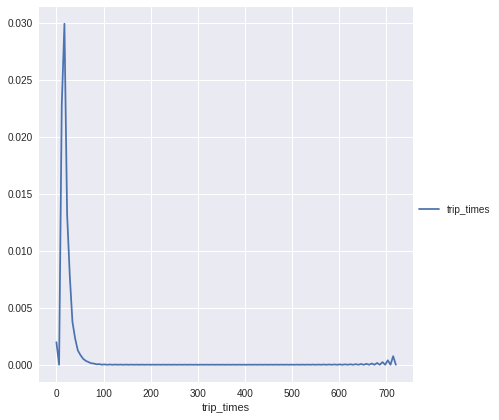

In [22]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [0]:
#converting the values to log-values to check for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

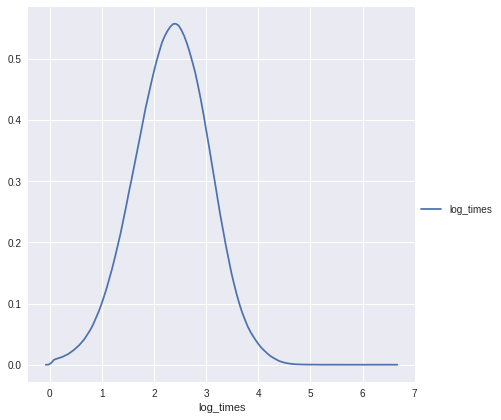

In [24]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

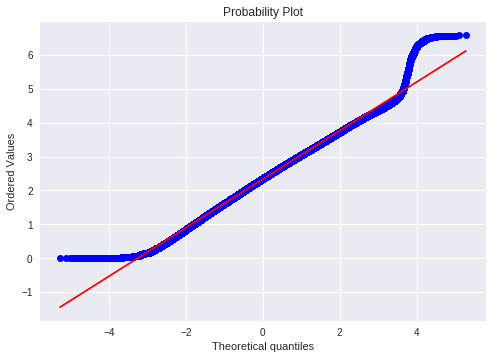

In [26]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

**Observation** : Q-Q plot showes that distrubution log-normal from std-dev -3 to 3